In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [14]:
import arviz as az
import edge_photometry as ep
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.infer import NUTS, MCMC
import seaborn as sns

numpyro.enable_x64()
numpyro.set_host_device_count(4)
sns.set_context('notebook')

In [20]:
def mock_Ierr(I):
    return min(np.exp(-1.68417623 + I*(-0.83340292 + I*0.03069122)), 0.22)
def mock_Verr(V):
    return min(np.exp(-0.675311 + V*(-0.91566766 + V*0.03140466)), 0.44)

To write down for posterity what made me feel insane, and caused a problem in the inference was the following: we drew true photometric magnitudes $\vec{A}$, and then determined the noise level based on these, so $\vec{\sigma}_A\left(\vec{A}\right)$ depends on $A$.  Then we mock "observed" photometry with $\vec{A}_\mathrm{obs} = \vec{A} + \vec{\sigma}_A\left(\vec{A}\right) \cdot \vec{\eta}$ with $\vec{\eta} \sim N(0,1)$.  It is not enough in this situation to *condition* on $\vec{\sigma}_A$, but rather the model must know about the actual dependence on $\vec{A}$ in the errorbars.  We need to fix this simulation condition or else we will continue to get biased inferences.

In [97]:
Nband = 2
N = 2000

errorbar_scaling = 1.0

mu_x = np.array([26.67723621, 27.97451744])
cov_x = np.array([[0.2458232 , 0.07516468],
                  [0.07516468, 0.11566182]])
scale_x = np.sqrt(np.diag(cov_x))

Aobs = []
sigma_obs = []
cov_obs = []
nf = 0
while nf < N:
    A = np.random.multivariate_normal(mu_x, cov_x)
    so = errorbar_scaling*np.array([0.011, 0.028])*np.random.uniform(low=1,high=2,size=2) # np.array([mock_Ierr(A[0]), mock_Verr(A[1])])
    co = np.diag(np.square(so))
    Ao = np.random.multivariate_normal(A, co)
    Aobs.append(Ao)
    sigma_obs.append(so)
    cov_obs.append(co)
    nf += 1

Aobs = np.array(Aobs)
sigma_obs = np.array(sigma_obs)
cov_obs = np.array(cov_obs)

In [86]:
# prec_obs = 1/(sigma_obs*sigma_obs)
# mean_prec = np.mean(prec_obs, axis=0)
# mean_cov = np.diag(1/mean_prec)

# Aobs = np.random.multivariate_normal(mu_x, cov_x + mean_cov, size=N)
# cov_obs = np.repeat(mean_cov[None,:,:], N, axis=0)

Aobs = []
for i in range(cov_obs.shape[0]):
    Aobs.append(np.random.multivariate_normal(mu_x, cov_x + cov_obs[i,:,:]))
Aobs = np.array(Aobs)

In [98]:
def mv_normal_model(xs_obs, xs_obs_cov):
    xs_obs = np.atleast_2d(xs_obs)
    xs_obs_cov = np.atleast_3d(xs_obs_cov)

    mu0 = np.mean(xs_obs, axis=0)
    sigma0 = np.std(xs_obs, axis=0)

    mu_x, _ = ep.mean_sample('x', mu0, sigma0)
    cov_x, _, _, _, _ = ep.covariance_sample('x', sigma0)

    cov_x_obs = cov_x[None,:,:] + xs_obs_cov
    mu_x_obs = mu_x[None,:]

    _ = numpyro.sample('xs_obs', dist.MultivariateNormal(mu_x_obs, covariance_matrix=cov_x_obs), obs=xs_obs)

In [99]:
num_chains=4
thin=1

sampler = NUTS(mv_normal_model, dense_mass=True)
mcmc = MCMC(sampler, num_warmup=1000*thin, num_samples=1000*thin, thinning=thin, num_chains=num_chains)
mcmc.run(ep.jax_prng_key(), Aobs, cov_obs)
trace = az.from_numpyro(mcmc)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

array([[<AxesSubplot:title={'center':'mu_x'}>,
        <AxesSubplot:title={'center':'mu_x'}>],
       [<AxesSubplot:title={'center':'scale_x'}>,
        <AxesSubplot:title={'center':'scale_x'}>]], dtype=object)

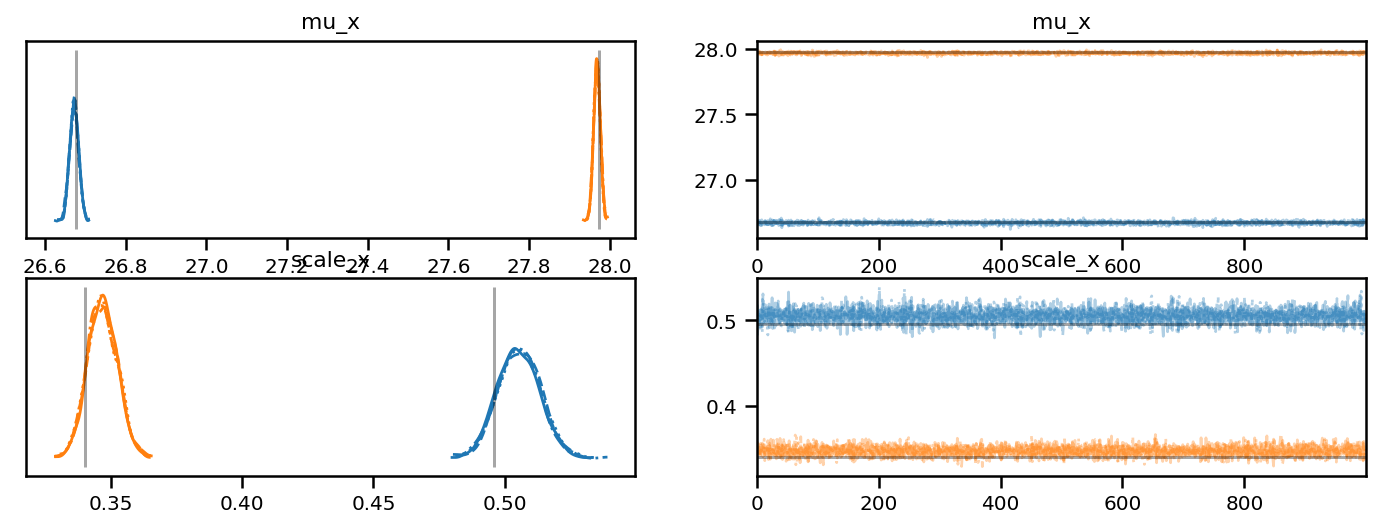

In [100]:
az.plot_trace(trace, var_names=['mu_x', 'scale_x'],
              lines=[('mu_x', {}, mu_x), ('scale_x', {}, scale_x)])

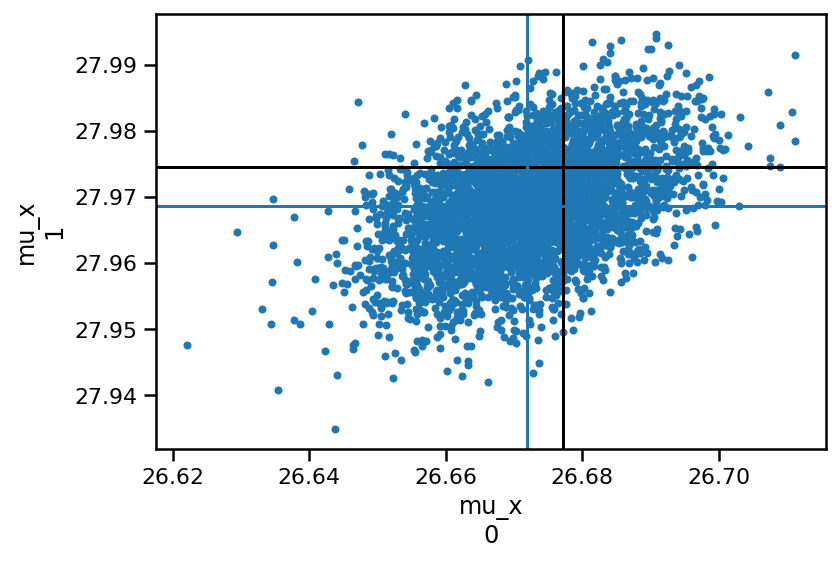

In [101]:
az.plot_pair(trace, var_names=['mu_x'])

plt.axhline(mu_x[1], color='k')
plt.axvline(mu_x[0], color='k')

m = np.mean(Aobs, axis=0)
plt.axhline(m[1], color=sns.color_palette()[0])
plt.axvline(m[0], color=sns.color_palette()[0])